In [4]:
import sys
sys.path.append('/home/arda/dinov2')
from distillation.models.dinov2 import DINOv2ViT

In [5]:
model = DINOv2ViT().model
model

Using cache found in /home/arda/.cache/torch/hub/facebookresearch_dinov2_main
/home/arda/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/arda/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/arda/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

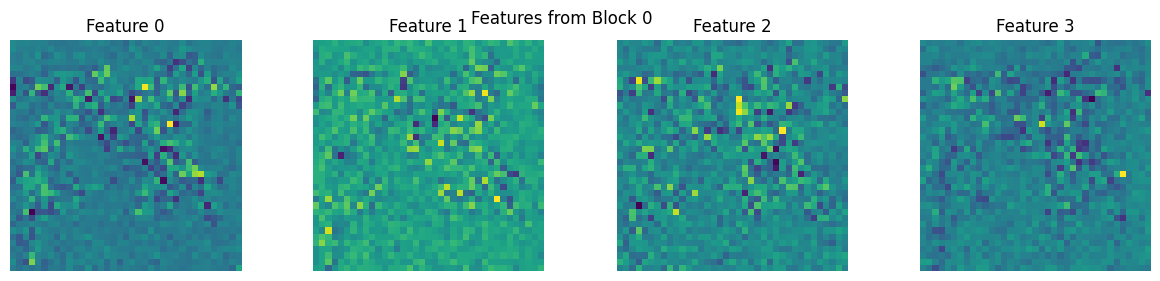

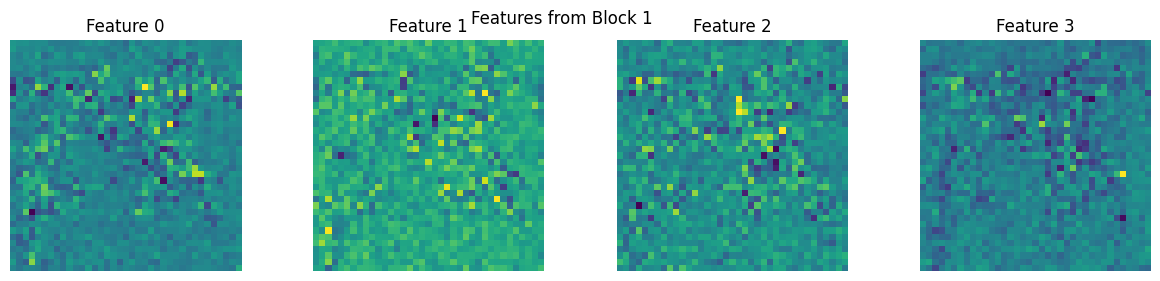

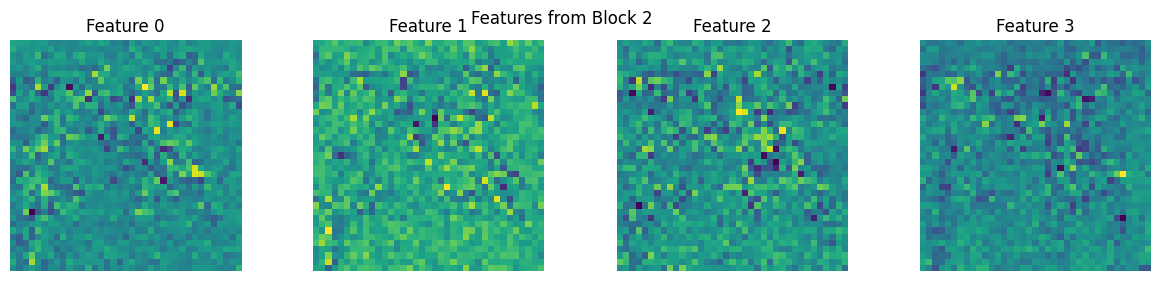

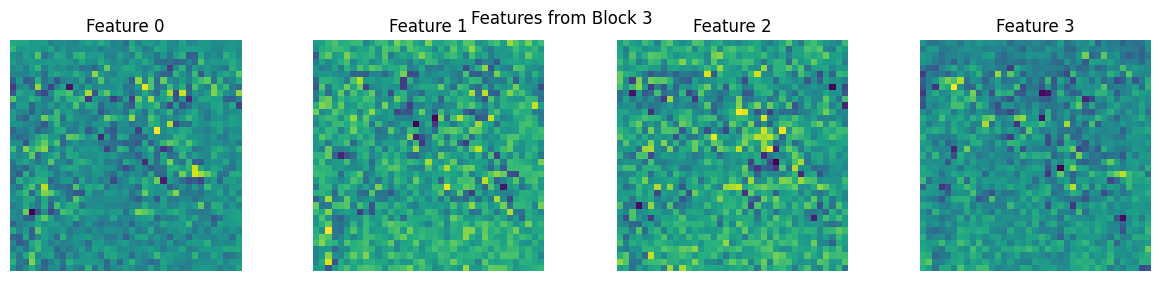

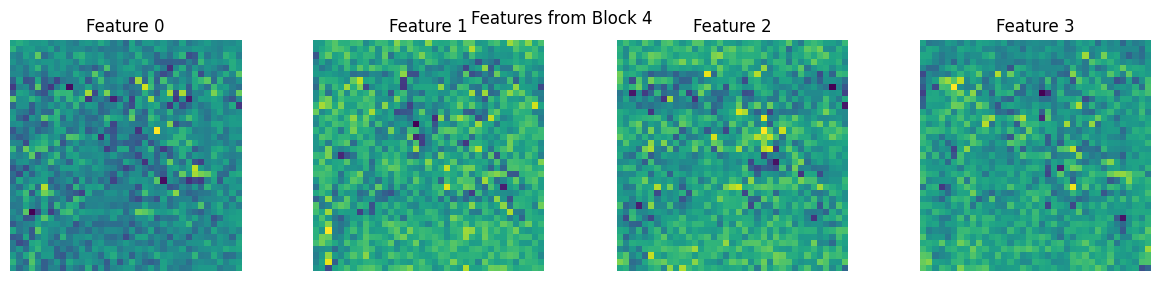

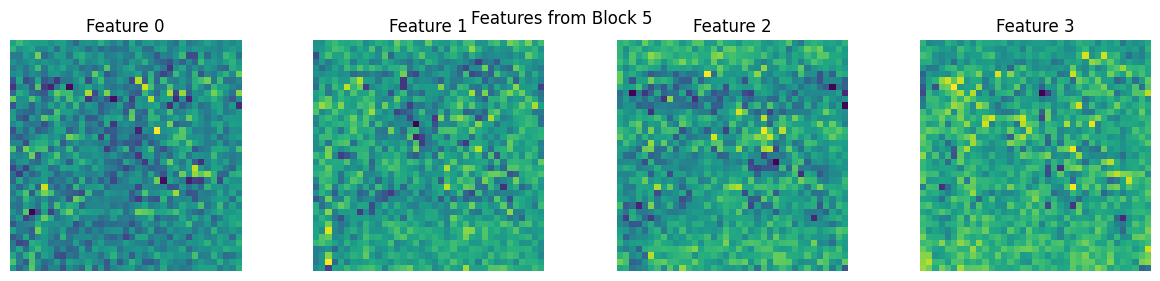

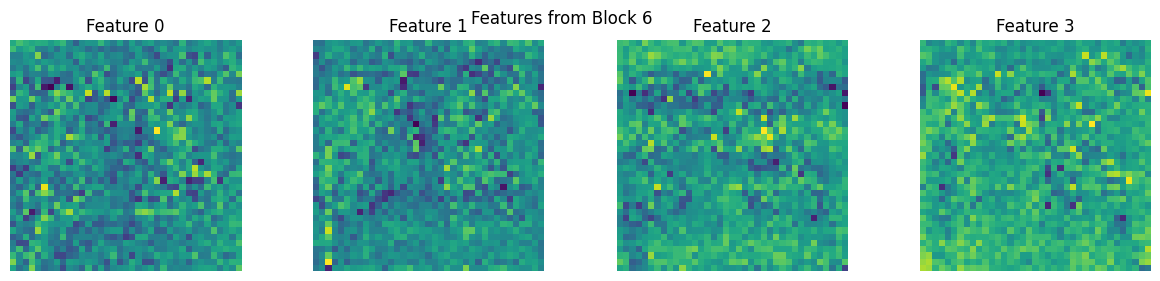

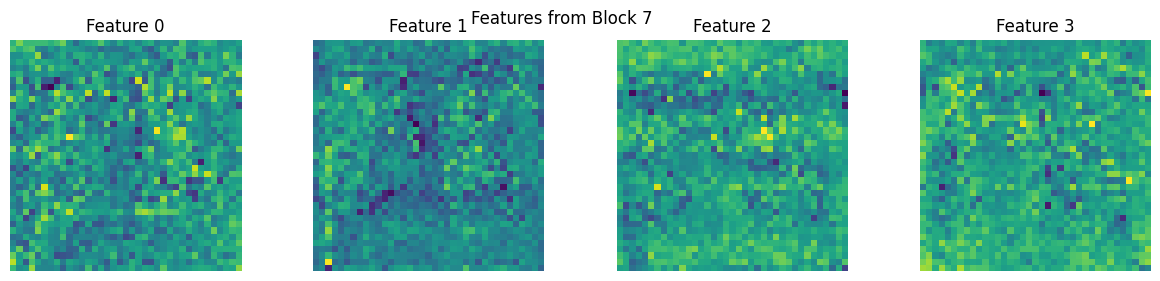

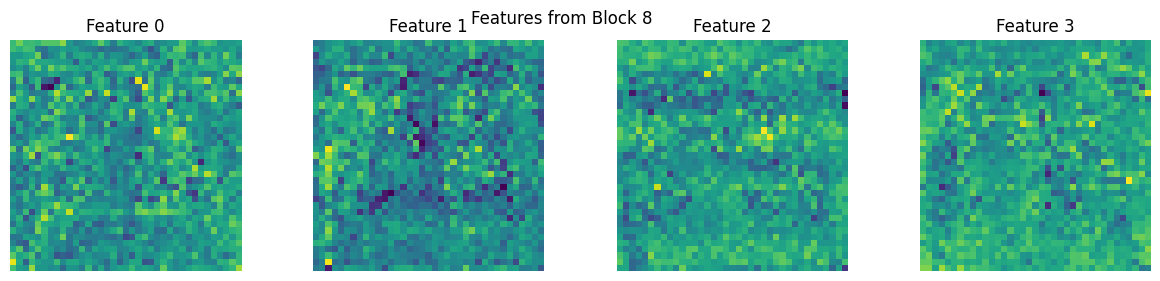

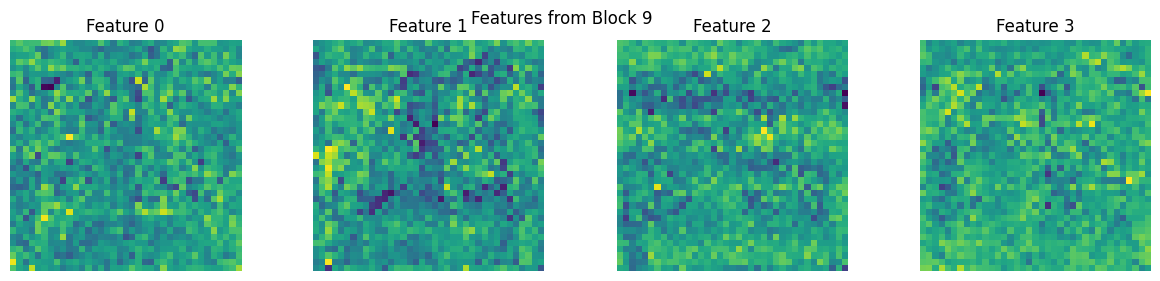

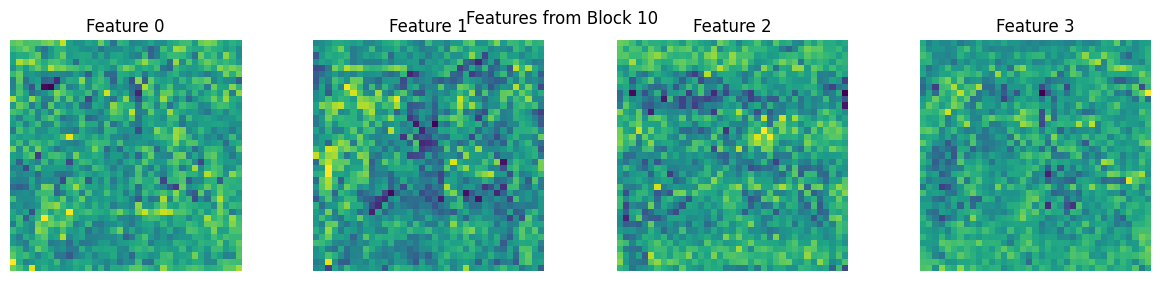

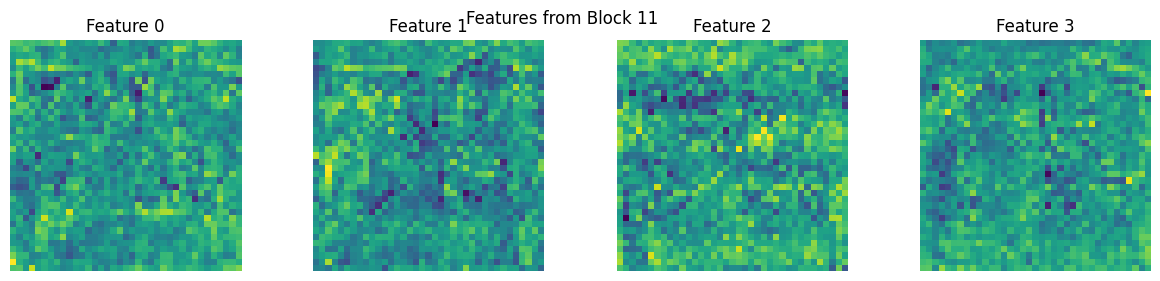

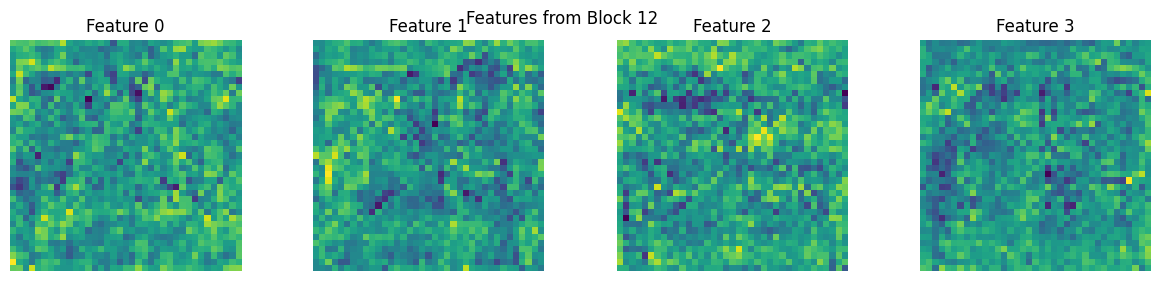

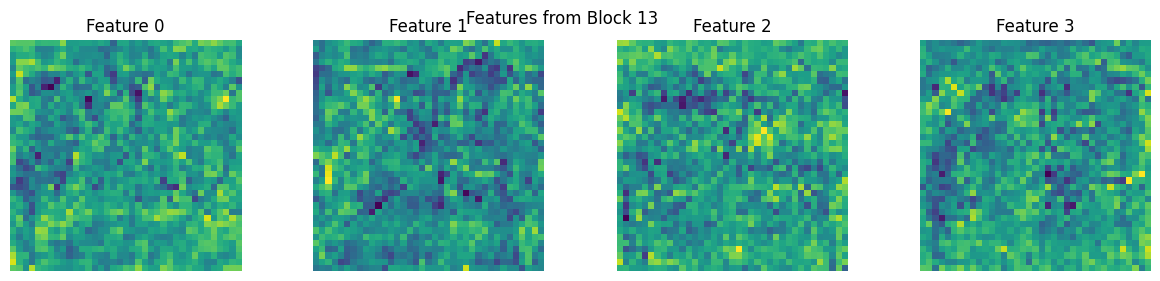

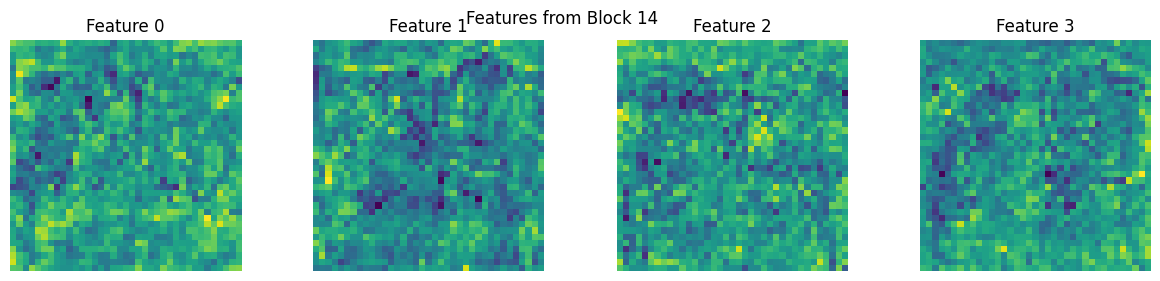

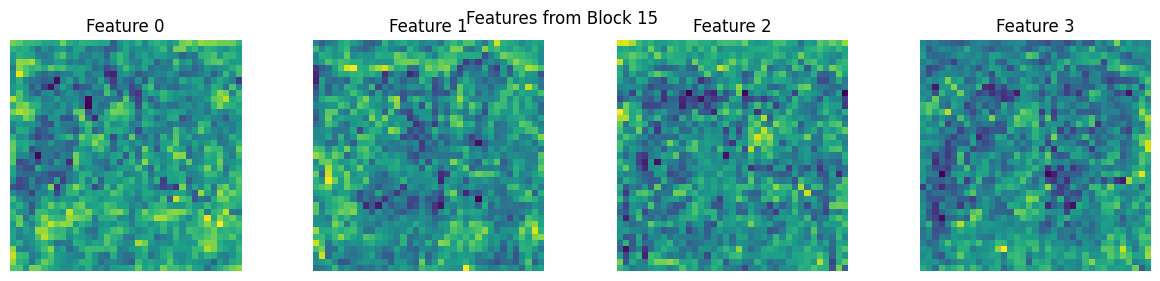

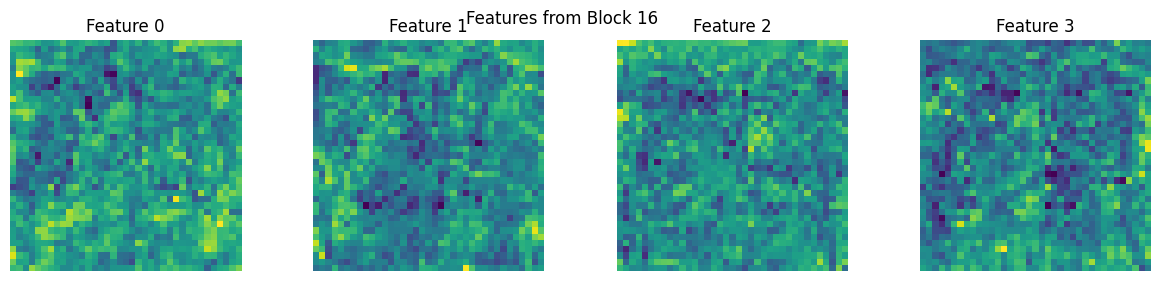

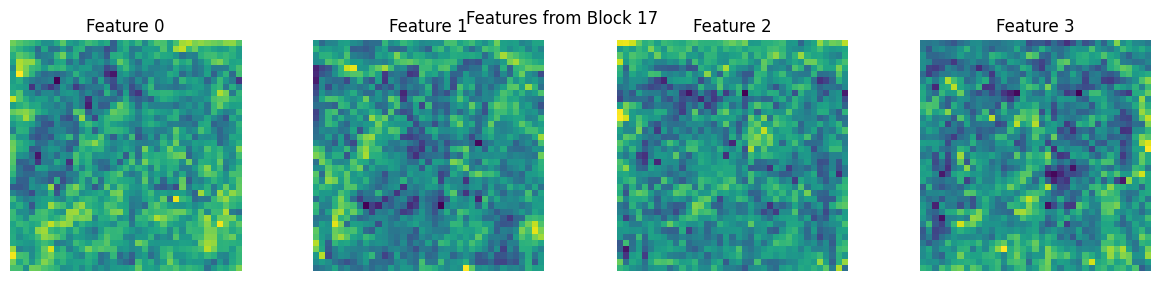

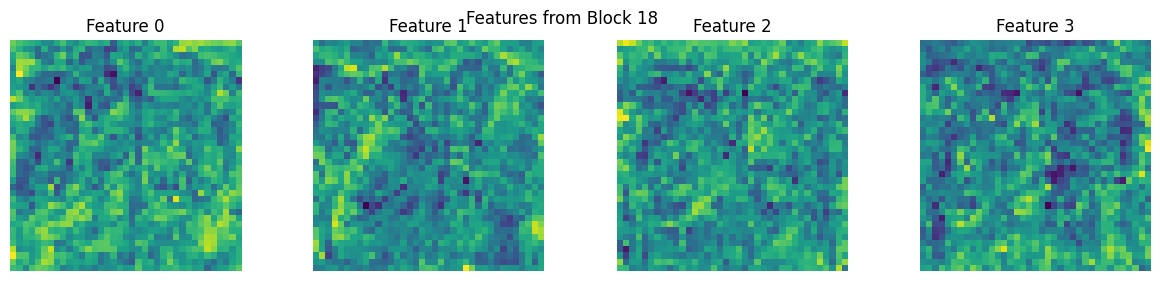

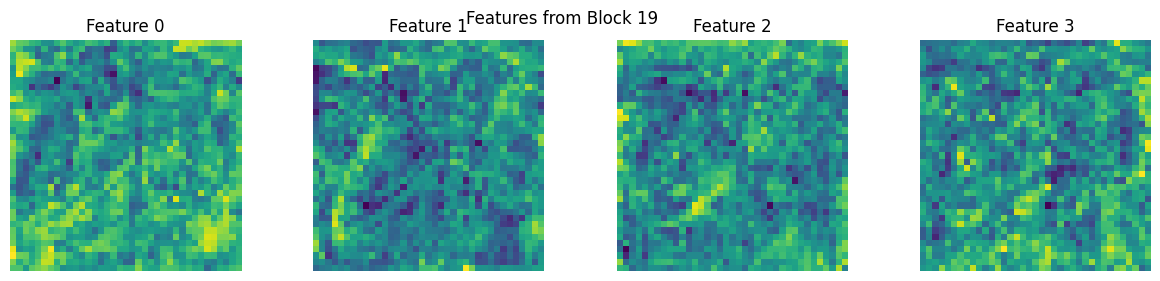

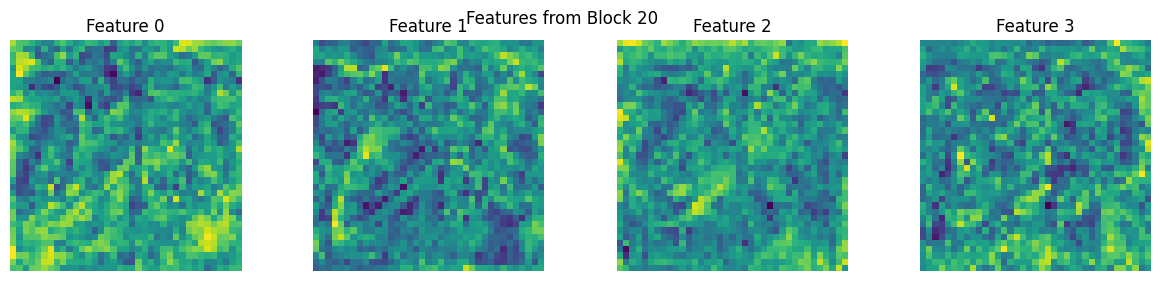

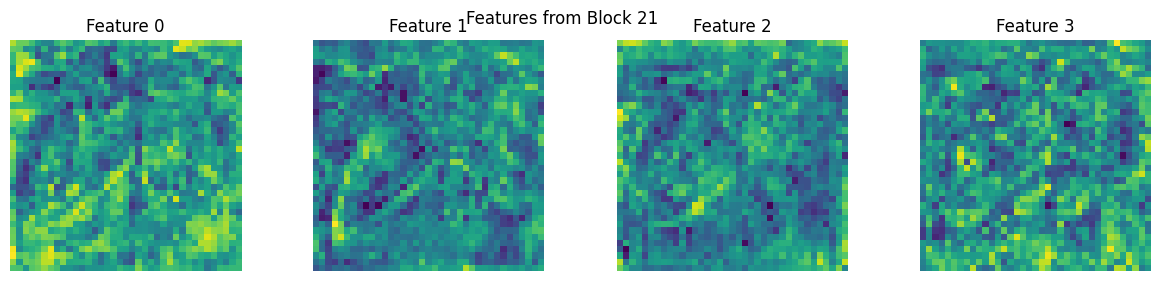

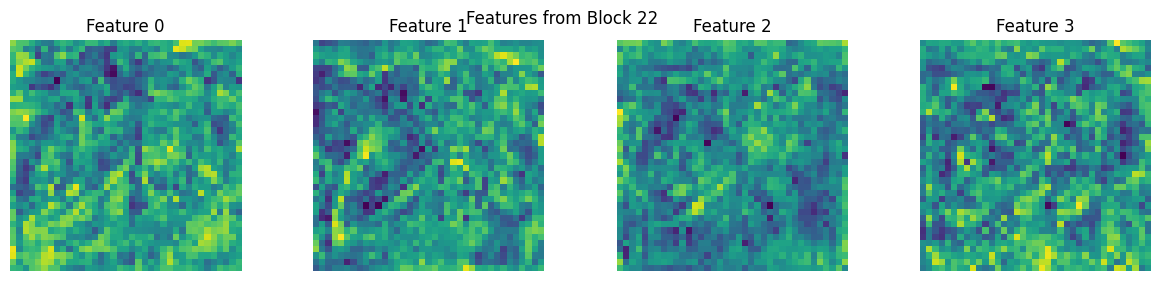

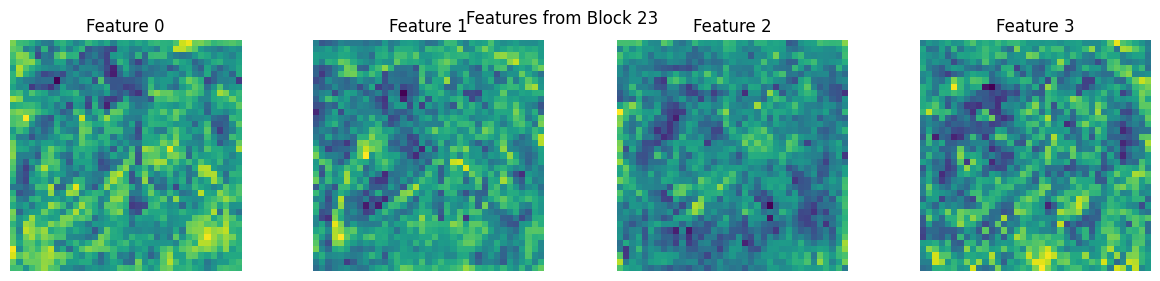

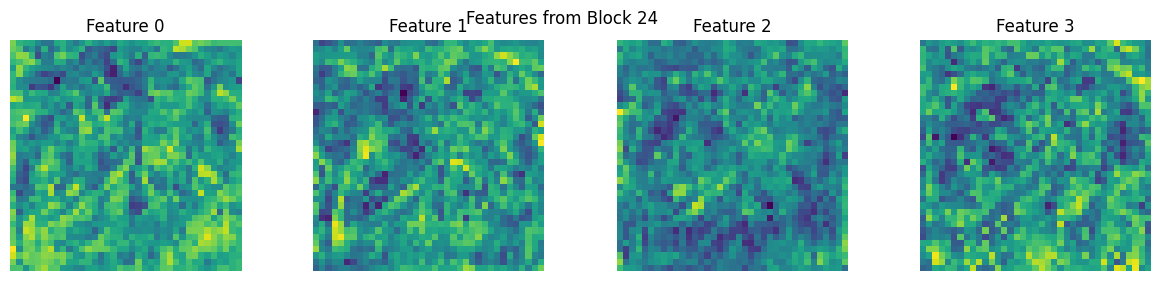

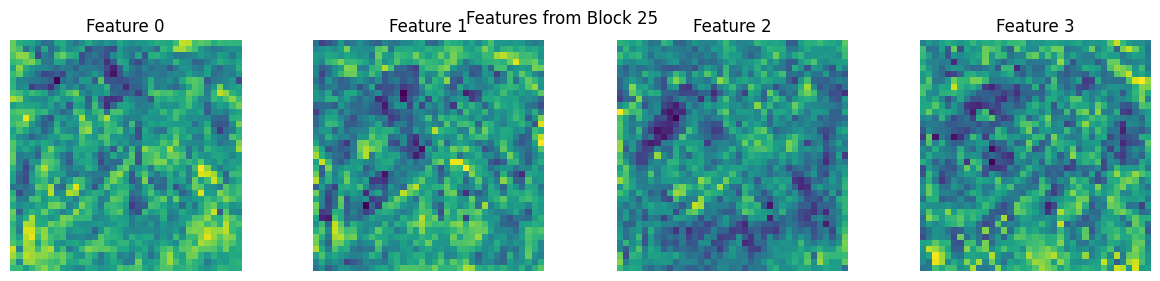

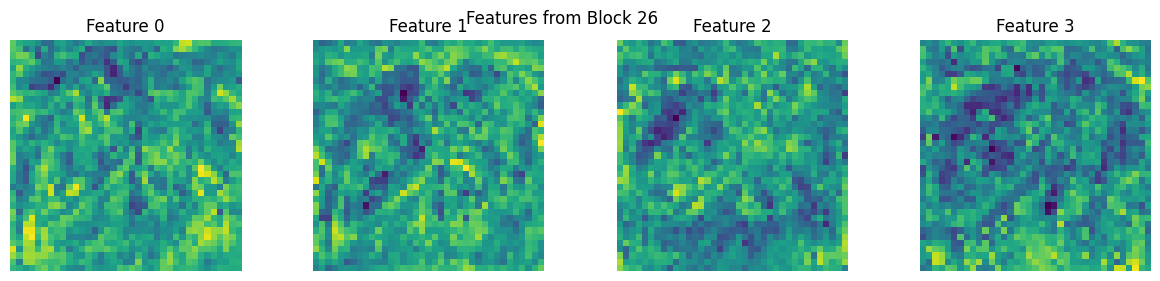

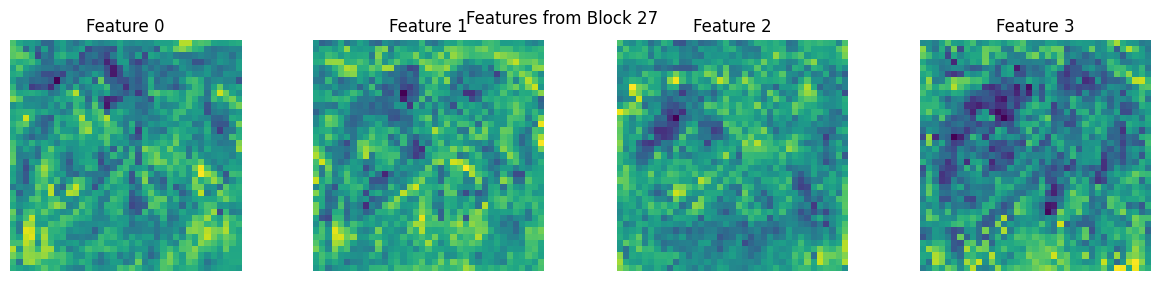

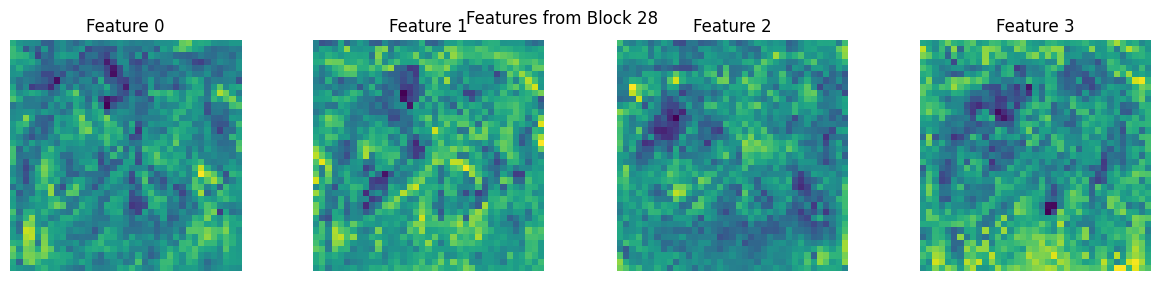

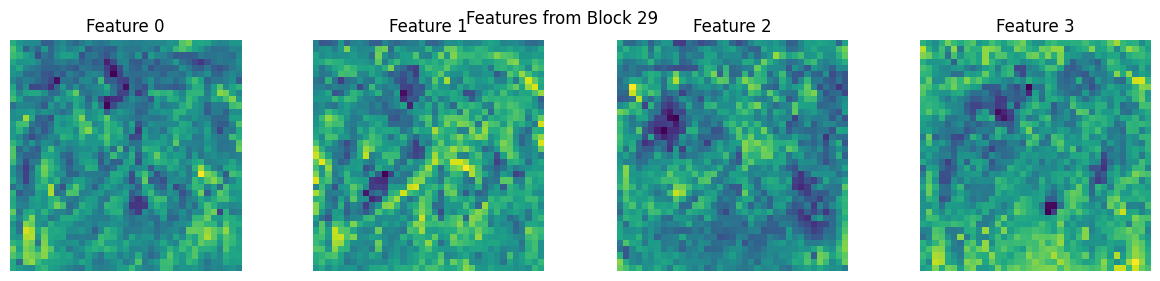

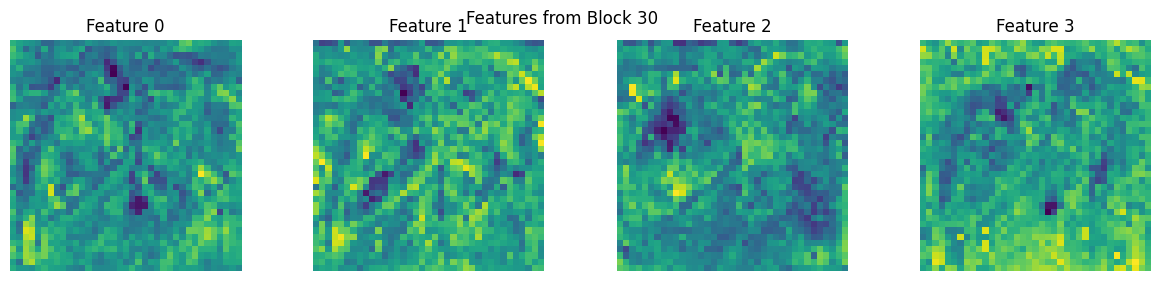

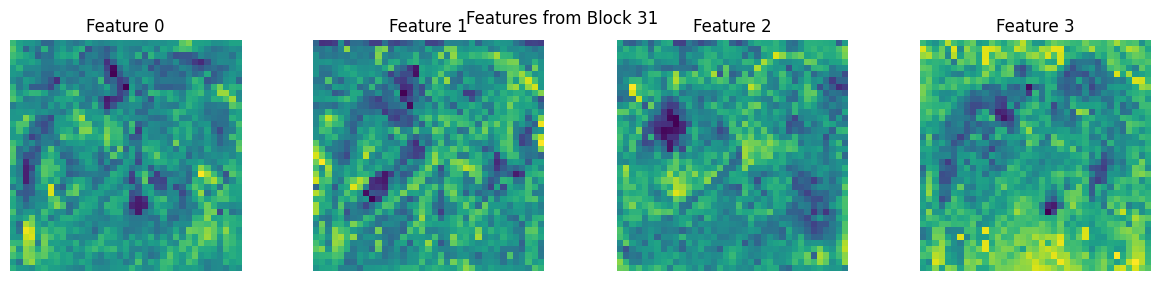

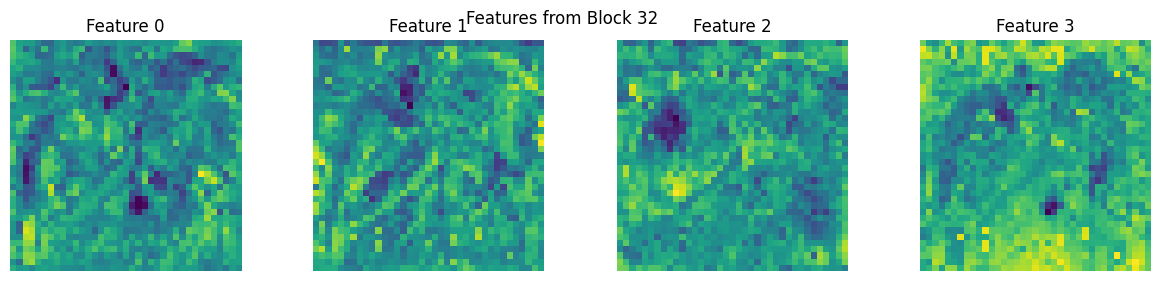

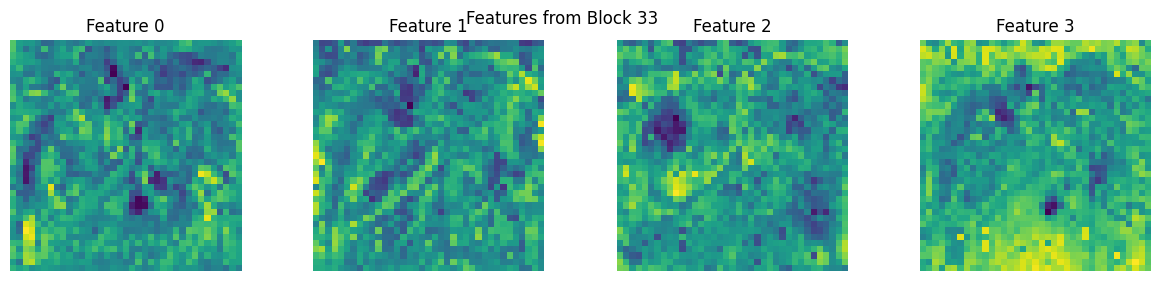

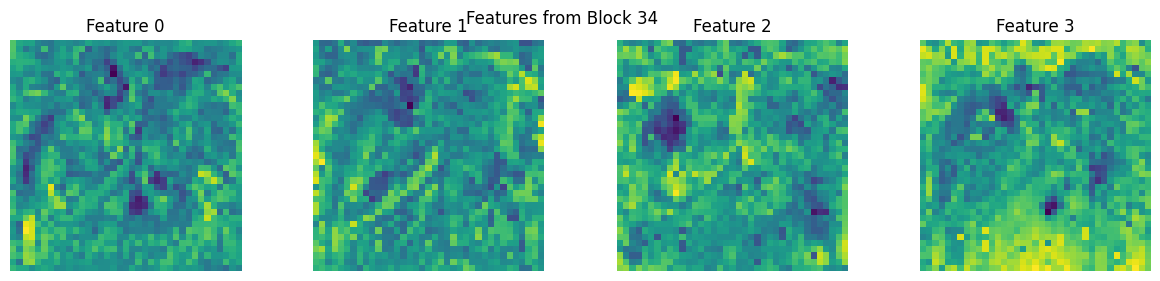

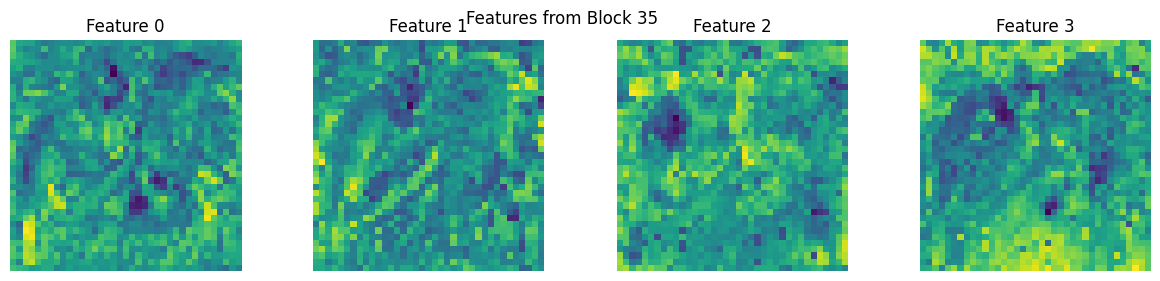

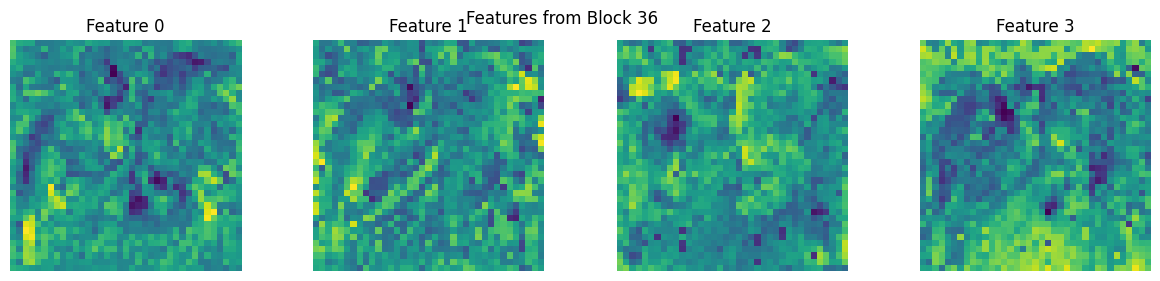

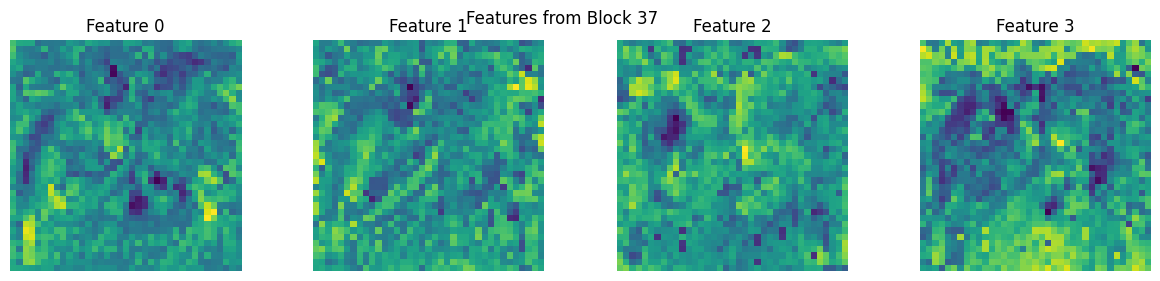

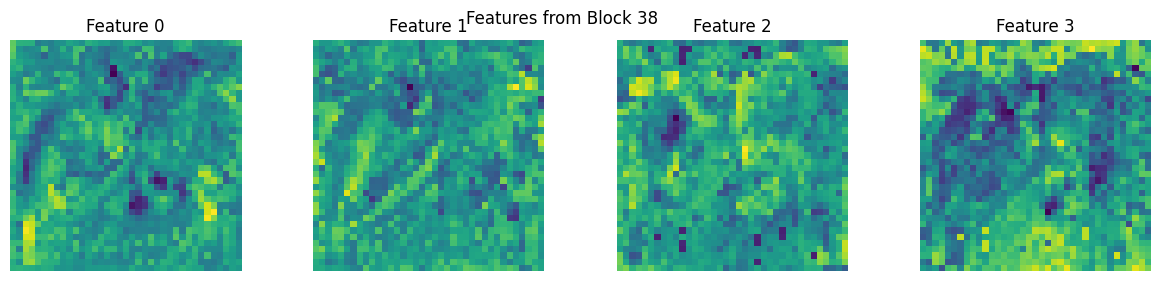

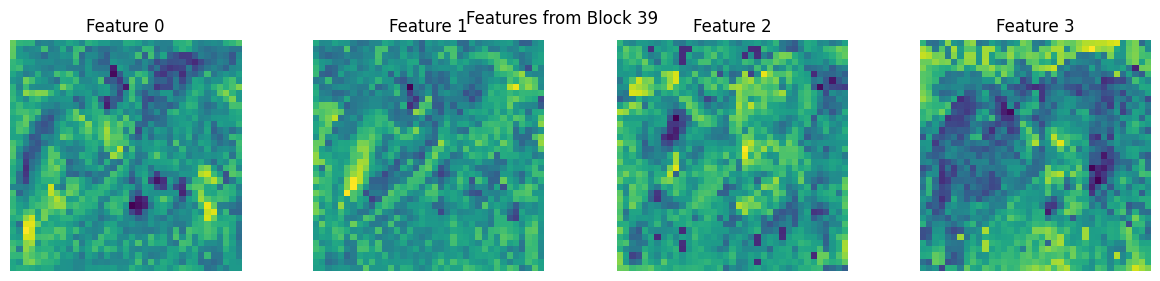

In [16]:
import torch
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO

# Download a sample image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Define transform for DINOv2
transform = transforms.Compose([
    transforms.Resize((518,518)),  # DINOv2 can handle arbitrary sizes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare image
x = transform(img).unsqueeze(0)  # Add batch dimension


# Register hooks to capture intermediate outputs
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

# Register hooks for blocks you want to observe
for i in range(len(model.blocks)):
    model.blocks[i].register_forward_hook(get_activation(f'block_{i}'))

# Forward pass
with torch.no_grad():
    output = model(x)

# Now you can access intermediate outputs
# for name, feat in activation.items():
#     print(f"{name} output shape: {feat.shape}")
    
# To visualize the first feature map from a specific block (e.g., block_0):
import matplotlib.pyplot as plt

def visualize_features(features, block_name, num_features=4):
    features = features.squeeze(0)[1:,:].permute(1,0).reshape(1536,37,37)  # Remove batch dimension
    fig, axes = plt.subplots(1, num_features, figsize=(15, 3))
    for i in range(num_features):
        axes[i].imshow(features[i].cpu().numpy())
        axes[i].axis('off')
        axes[i].set_title(f'Feature {i}')
    plt.suptitle(f'Features from {block_name}')
    plt.show()
# Visualize features from all blocks
for i in range(len(model.blocks)):
    visualize_features(activation[f'block_{i}'], f'Block {i}')


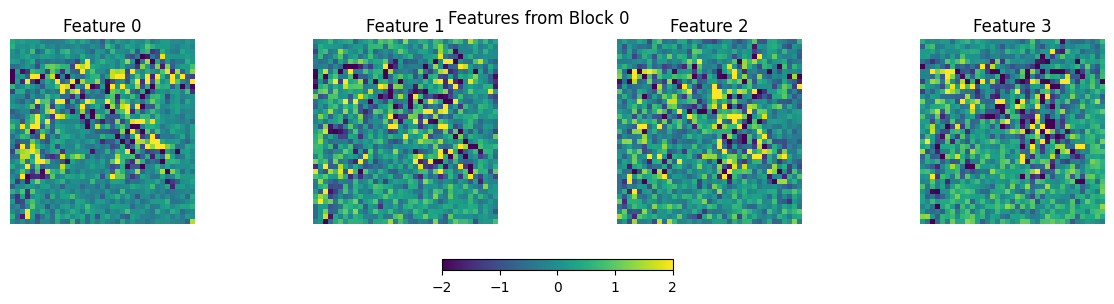

<Figure size 640x480 with 0 Axes>

In [22]:
import numpy as np
from matplotlib.animation import FuncAnimation

def animate_features(activations, num_features=4):
    # Set up the figure and subplots
    fig, axes = plt.subplots(1, num_features, figsize=(15, 3))
    
    # Initialize empty images
    images = []
    for i in range(num_features):
        # Initialize with a proper colormap and normalize initial values
        img = axes[i].imshow(
            np.zeros((37, 37)),
            cmap='viridis',  # Use a perceptually uniform colormap
            vmin=-2,         # Set initial value range
            vmax=2
        )
        axes[i].axis('off')
        axes[i].set_title(f'Feature {i}')
        images.append(img)
    
    def update(frame):
        # Get features for current block
        features = activations[f'block_{frame}'].squeeze(0)[1:,:].permute(1,0).reshape(1536,37,37)
        features = features.cpu().numpy()
        
        # Update each feature map
        for i in range(num_features):
            # Normalize the feature map for better visualization
            feat_map = features[i]
            feat_map = (feat_map - feat_map.mean()) / (feat_map.std() + 1e-6)
            images[i].set_array(feat_map)
        
        plt.suptitle(f'Features from Block {frame}')
        return images
    
    # Create animation
    anim = FuncAnimation(
        fig, 
        update,
        frames=len(model.blocks),
        interval=500,  # 500ms between frames
        blit=True
    )
    
    # Add colorbar
    plt.colorbar(images[0], ax=axes, orientation='horizontal', fraction=0.05)
    
    return fig, anim

# Create and display animation
fig, anim = animate_features(activation)

from IPython.display import HTML
HTML(anim.to_jshtml())

In [7]:
import torch
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/arda/dinov2')
from distillation.models.dinov2 import DINOv2ViT

# Initialize model
model = DINOv2ViT()

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Define transform for DINOv2
transform = transforms.Compose([
    transforms.Resize((518,518)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare image
x = transform(img).unsqueeze(0)


Using cache found in /home/arda/.cache/torch/hub/facebookresearch_dinov2_main


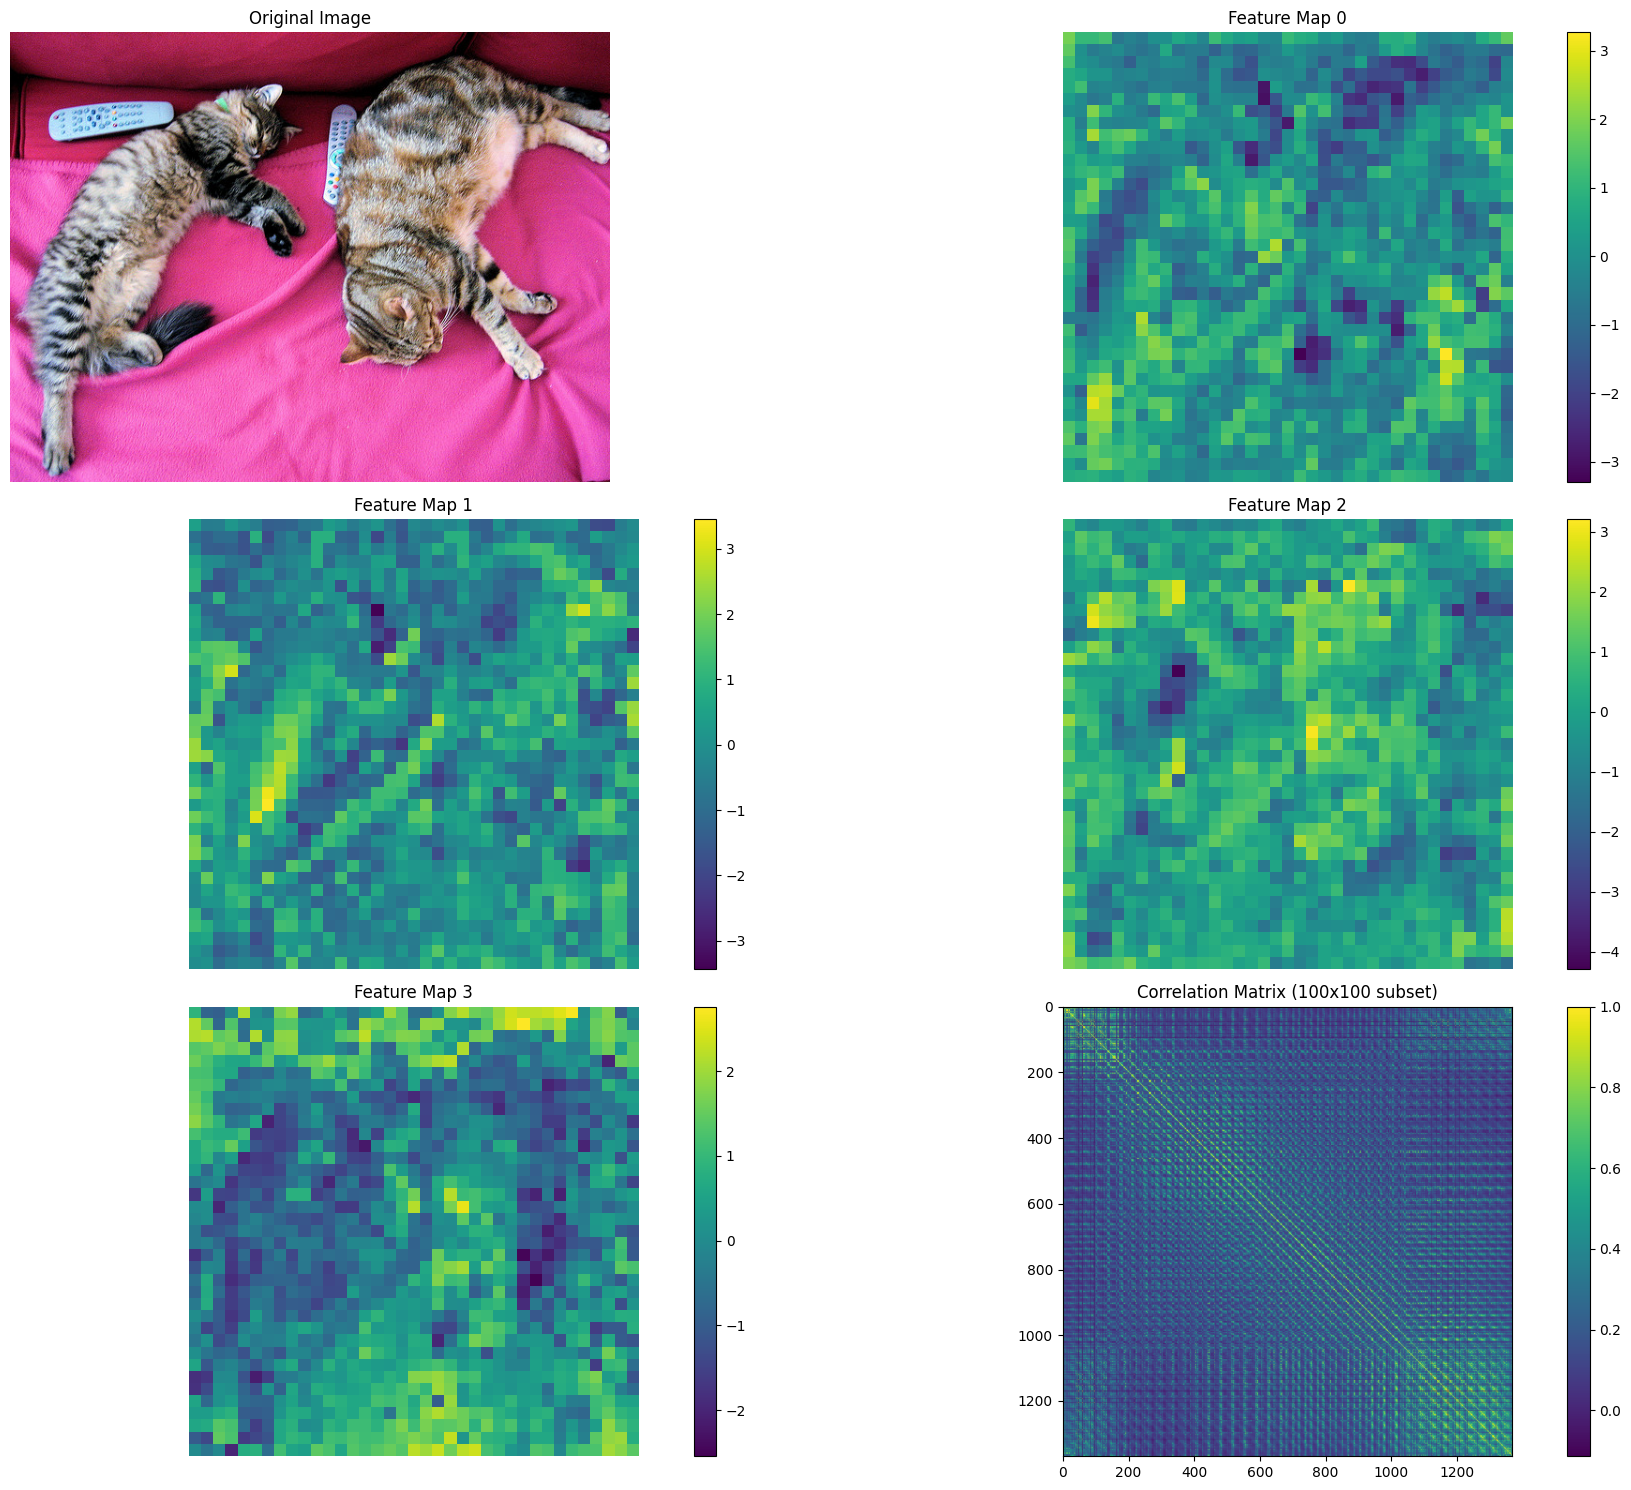

Original features shape: torch.Size([1, 1536, 37, 37])
Spatial features shape: torch.Size([1536, 37, 37])
Flattened features shape: torch.Size([1536, 1369])
Normalized features shape: torch.Size([1536, 1369])
Correlation matrix shape: torch.Size([1369, 1369])


In [11]:
with torch.no_grad():
    # Get features directly from model output
    features = model(x)['feature_map']  # Shape: [B, C, H, W]

def visualize_dino_processing(features):
    # Original shape: [1, 1536, 37, 37]
    B, C, H, W = features.shape
    
    # Step 1: Features are already in spatial format
    spatial_features = features.squeeze(0)  # Remove batch dim: [1536, 37, 37]
    
    # Step 2: Flatten spatial dimensions as in DINO loss
    flattened_features = spatial_features.flatten(-2,-1)  # Shape: [1536, 1369]
    
    # Step 3: L2 normalize features
    normalized_features = flattened_features/flattened_features.norm(dim=0, keepdim=True)
    
    # Step 4: Compute correlation matrix
    correlation_matrix = torch.matmul(normalized_features.T, normalized_features)  # [1369, 1369]
    
    # Visualizations
    fig = plt.figure(figsize=(20, 15))
    
    # Original image
    plt.subplot(3, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Feature maps (showing first 4 channels)
    plt.subplot(3, 2, 2)
    for i in range(4):
        plt.subplot(3, 2, 2 + i)
        feat_map = spatial_features[i].cpu()
        feat_map = (feat_map - feat_map.mean()) / feat_map.std()  # Normalize for visualization
        plt.imshow(feat_map, cmap='viridis')
        plt.title(f'Feature Map {i}')
        plt.colorbar()
        plt.axis('off')
    
    # Correlation matrix
    plt.subplot(3, 2, 6)
    plt.imshow(correlation_matrix.cpu(), cmap='viridis')
    plt.title('Correlation Matrix (100x100 subset)')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    # Print shapes at each step
    print(f"Original features shape: {features.shape}")
    print(f"Spatial features shape: {spatial_features.shape}")
    print(f"Flattened features shape: {flattened_features.shape}")
    print(f"Normalized features shape: {normalized_features.shape}")
    print(f"Correlation matrix shape: {correlation_matrix.shape}")
    
    return spatial_features, flattened_features, normalized_features, correlation_matrix

# Run visualization
spatial_features, flattened_features, normalized_features, correlation_matrix = visualize_dino_processing(features)

In [27]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from distillation.models.dinov2 import DINOv2ViT
import ipywidgets as widgets
from IPython.display import display
# Forward pass
with torch.no_grad():
    features = model(x)['feature_map']  # Shape: [1, 1536, 37, 37]

# Prepare correlation matrix once
B, C, H, W = features.shape
flattened_features = features.squeeze(0).flatten(-2,-1)  # [1536, 1369]
normalized_features = flattened_features/flattened_features.norm(dim=0, keepdim=True)
correlation_matrix = torch.matmul(normalized_features.T, normalized_features)  # [1369, 1369]

def update_plot(x, y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original image
    axes[0].imshow(img)
    axes[0].scatter(x * (518/W), y * (518/H), c='red', s=100)
    axes[0].set_title(f'Selected Pixel: ({x}, {y})')
    axes[0].axis('off')
    
    # Similarity map
    pixel_idx = y * W + x
    similarities = correlation_matrix[pixel_idx].reshape(H, W)
    sim_map = axes[1].imshow(similarities.cpu(), cmap='viridis')
    axes[1].scatter(x, y, c='red', s=100)
    axes[1].set_title('Similarity Map\nBrighter = More Similar')
    plt.colorbar(sim_map, ax=axes[1])
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Create sliders
x_slider = widgets.IntSlider(
    value=18, 
    min=0, 
    max=36, 
    description='X coordinate:'
)

y_slider = widgets.IntSlider(
    value=18, 
    min=0, 
    max=36, 
    description='Y coordinate:'
)

# Create interactive output
out = widgets.interactive(update_plot, x=x_slider, y=y_slider)
display(out)